In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from PIL import Image
from tqdm.notebook import tqdm

### Check if host machine has GPU available

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Load Images
#### Apply transforms
Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225]. (see these same values used in an official PyTorch example [here](https://github.com/pytorch/examples/blob/42e5b996718797e45c46a25c55b031e6768f8440/imagenet/main.py#L89-L101))

In [3]:
data_dir = 'data'

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test = datasets.ImageFolder(data_dir+'/val', transform=test_transforms)

testloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True, num_workers=4)

In [4]:
len(test)

2000

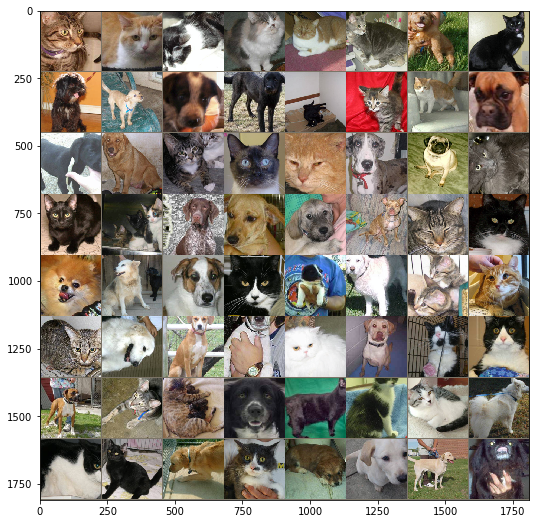

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = torchvision.utils.make_grid(inp)
    # in tensor, image is (batch, width, height)
    # so you have to transpose it to (width, height, batch) 
    # in numpy to show it.
    inp = inp.numpy().transpose((1, 2, 0))
    # de-normalise images to get original colours
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(9,9))
    plt.imshow(inp)

# Get a batch of testing data
inputs, labels = next(iter(testloader))
# show images in batch
imshow(inputs)

## Sample some test images and show predicted labels

In [6]:
# load model
model = torch.load('./models/densenet.h5').to(device)

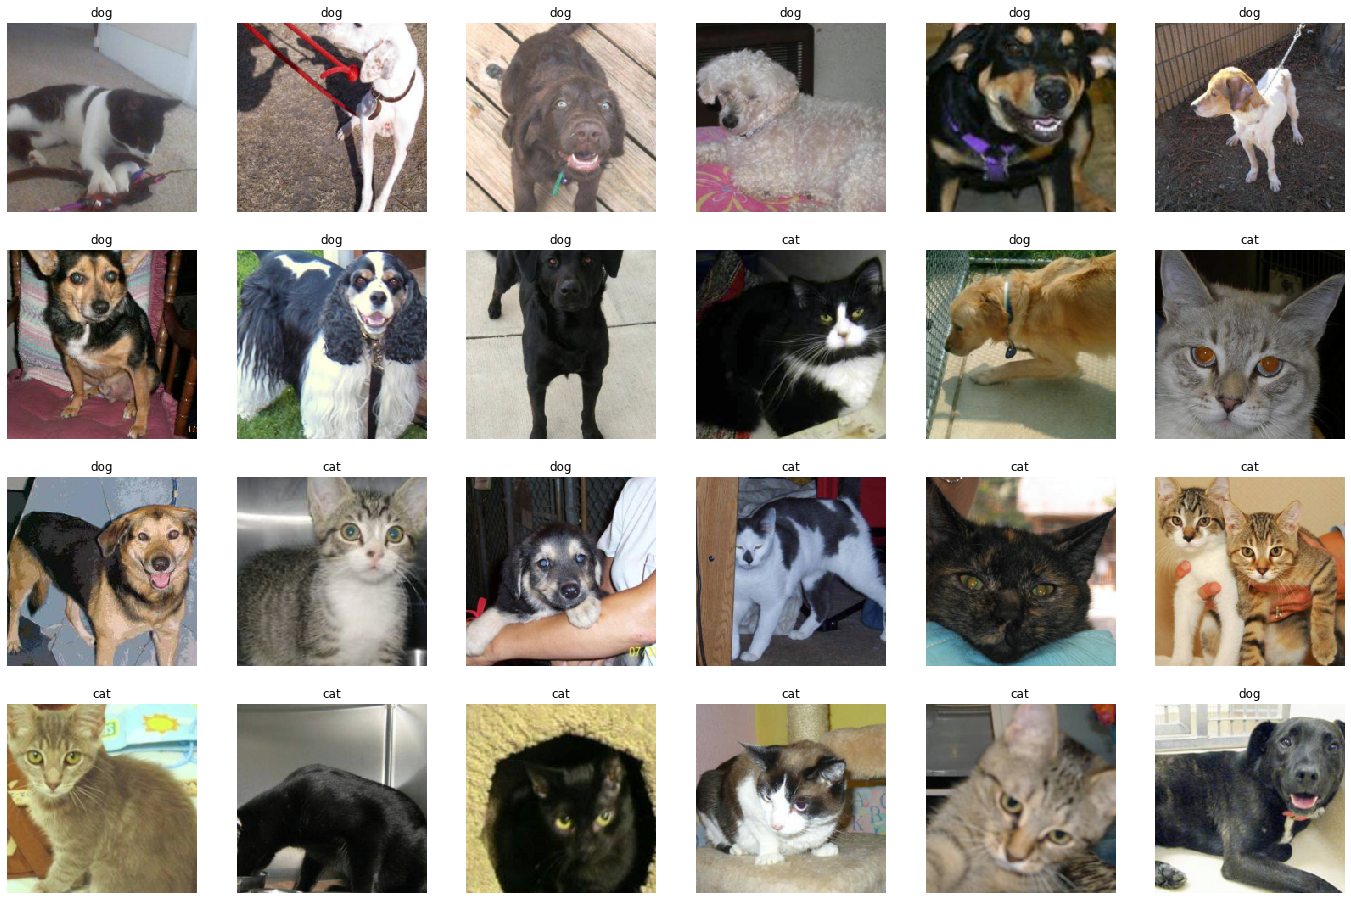

In [7]:
model.eval()

samples, _ = iter(testloader).next()  # ToDo: change to test images
samples = samples.to(device)
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    sample = np.transpose(sample, (1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    sample = std * sample + mean
    sample = np.clip(sample, 0, 1)
    plt.imshow(sample)

## Classify single image
In the case that we want to pass a single image to the model from a file, we will need to load it using the Python Imaging Library (PIL), then apply the same transformations that were applied to the training data and finally reshape the resulting tensor into a batch one single image.

Predicted label: dog


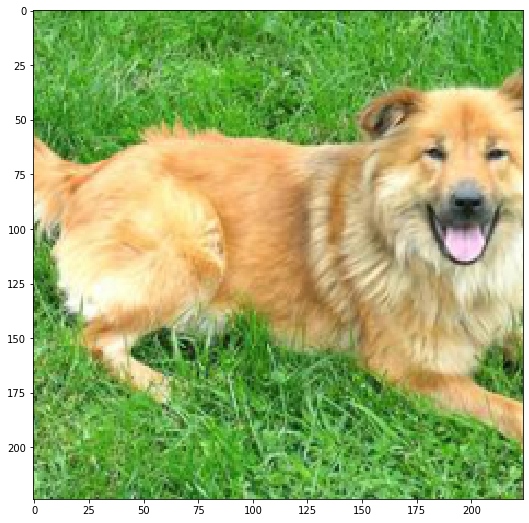

In [8]:
img_path = 'data/test/4.jpg'

im = Image.open(img_path)
im = test_transforms(im).unsqueeze(0)  # reshape batch size = 1
imshow(im)

im = im.to(device)

model.eval()
output = model(im)
pred = torch.argmax(output, dim=1)

print('Predicted label:', ad[pred.item()])